In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import openpyxl
from openpyxl import load_workbook
import os
#from ccfj import GetStationPairs
from geopy.distance import great_circle
#import shapefile
import geopandas as gp
import yaml
import math

from scipy.spatial import ConvexHull
from scipy.interpolate import griddata
from shapely.geometry import Point, Polygon

from pykrige.ok import OrdinaryKriging
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.colors import Normalize

In [2]:
import sys
sys.path.append(r'../tools_F-J/')
from toollib_standard import plotlib

In [3]:
flag_project = 1 # 0--regular; 1--repartrition

In [4]:
if flag_project == 0:
    file_project = 'a-project.yml'
elif flag_project == 1:
    file_project = 'a-project_repar.yml'
elif flag_project == 2:
    file_project = 'a-project_voro.yml'
    
with open(file_project, 'r', encoding='utf-8') as f:
    proj = yaml.load(f.read(), Loader=yaml.FullLoader)
name_project = proj['name']

#name_project = 'project/output_FJSJ_16-01/'               
#name_project = 'project_repartrition/repartrition_01-03/'               
#name_project = 'project_voronoi/voronoi_01-03/'         

In [5]:
with open('0_config.yml', 'r', encoding='utf-8') as f:
    dir_config = yaml.load(f.read(), Loader=yaml.FullLoader)
dir_project_workspace = dir_config['dir_project_workspace']
dir_CC_workspace = dir_config['dir_CC_workspace']
print('dir_CC_workspace: ', dir_CC_workspace)
print('dir_project_workspace: ', dir_project_workspace)
dir_project = os.path.join(dir_project_workspace, name_project)
print('dir_project: ', dir_project)

dir_CC_workspace:  /shdisk/rem2/Harmon/F-J/San/
dir_project_workspace:  /shdisk/rem2/Harmon/F-J/San/
dir_project:  /shdisk/rem2/Harmon/F-J/San/project_repartition_v4.0/output_repar_v9.2_01-01/


In [6]:
filename = dir_project+'Basic_info.yml'
with open(filename, 'r', encoding='utf-8') as f:
    info_basic = yaml.load(f.read(), Loader=yaml.FullLoader)
filename_bi = dir_project+'Basic_info.npy'
info_basic_bi = np.load(filename_bi, allow_pickle='TRUE').item()      # setting dictionary

In [7]:
dir_model_fund = dir_project + info_basic['dir_model_fund']
dir_model = dir_project + info_basic['dir_model']
dir_image = dir_project + info_basic['dir_image']+'Vs_compare/'
if not os.path.exists(dir_image):
    os.makedirs(dir_image)
dir_inv_dispernet = dir_project + info_basic['dir_inv_dispernet']
dir_partition = dir_project + info_basic['dir_partition']
key_subworks = info_basic['key_subworks']
M = len(key_subworks)
key_subworks

['1--08-03',
 '2--09-03',
 '3--10-03',
 '4--11-03',
 '5--12-03',
 '6--13-03',
 '7--14-03',
 '8--15-03',
 '9--16-03',
 '10--18-03',
 '12--20-03',
 '13--21-03',
 '15--23-03',
 '17--25-03',
 '18--26-03',
 '19--27-03',
 '20--28-03',
 '21--29-03',
 '22--30-03',
 '23--31-03',
 '25--33-03',
 '26--34-03',
 '28--36-03',
 '30--41-03',
 '31--42-03',
 '33--46-03',
 '34--47-03',
 '35--48-03',
 '36--52-03',
 '37--53-03',
 '38--07-04',
 '39--08-04',
 '40--09-04',
 '41--10-04',
 '42--12-04',
 '43--13-04',
 '44--17-04',
 '45--20-04',
 '46--21-04',
 '48--23-04',
 '49--24-04',
 '50--25-04',
 '51--27-04',
 '52--28-04',
 '53--29-04',
 '54--30-04',
 '55--31-04',
 '56--32-04',
 '57--33-04',
 '58--34-04',
 '59--35-04',
 '60--36-04',
 '63--47-04',
 '65--49-04',
 '66--52-04',
 '67--53-04',
 '68--08-05',
 '69--12-05',
 '70--13-05',
 '71--14-05',
 '72--16-05',
 '75--22-05',
 '76--24-05',
 '77--26-05',
 '78--27-05',
 '79--28-05',
 '80--29-05',
 '81--30-05',
 '84--35-05',
 '85--36-05',
 '86--37-05',
 '88--39-05',
 

In [8]:
def GetStationPairs(nsta):
    StationPair = []
    for ii in range(nsta):
        for jj in range(ii+1,nsta):
            StationPair.append(ii)
            StationPair.append(jj)
    StationPair = np.array(StationPair,dtype=np.int32)
    return StationPair

In [9]:
stalistname_all = info_basic['stalistname_all']
stainfo = pd.read_excel(stalistname_all)
nsta_all = len(stainfo.iloc[:,0])
StationPairs_all = GetStationPairs(nsta_all)
nPairs_all = int(len(StationPairs_all)/2)
stalist_all = stainfo['Station'].tolist() 
lat_stations_all =  stainfo['latitude'].tolist() 
lon_stations_all =  stainfo['longitude'].tolist() 
elevation_stations_all = stainfo['elevation'].tolist()

In [10]:
stations_partition = {}
lat_stations_partition = {}
lon_stations_partition = {}
lat_centroid_partition = []
lon_centroid_partition = []
num_stations = []
for key in key_subworks:
    filepath = dir_partition + str(key) + '.txt'
    stations_this, lat_stations_this, lon_stations_this = np.loadtxt(filepath, dtype='str' , unpack=True)
    stations_partition[key] = stations_this
    lat_stations_partition[key] = lat_stations_this.astype(float)
    lon_stations_partition[key] = lon_stations_this.astype(float)
    num_stations.append(len(stations_this))
    lat_centroid_partition.append(np.mean(lat_stations_this.astype(float)))
    lon_centroid_partition.append(np.mean(lon_stations_this.astype(float)))

In [11]:
#points = np.column_stack((lon_stations_all, lat_stations_all))
points = np.column_stack((lon_centroid_partition, lat_centroid_partition))
hull = ConvexHull(points)
polygon = Polygon(points[hull.vertices])
index_sta = []
lon_stations_in = []
lat_stations_in = []
elevation_stations_in = []
for i in range(len(lon_stations_all)):
    if polygon.contains(Point(lon_stations_all[i], lat_stations_all[i])):
        index_sta.append(i)
        lon_stations_in.append(lon_stations_all[i])
        lat_stations_in.append(lat_stations_all[i])
        elevation_stations_in.append(elevation_stations_all[i])

In [12]:
faults = np.load('clark_faults.npy', allow_pickle='TRUE').item()

In [13]:
def compute_affine_transform(original_points, target_points):
    A_matrix = np.array([[original_points[0][0], original_points[0][1], 1, 0, 0, 0],
                         [0, 0, 0, original_points[0][0], original_points[0][1], 1],
                         [original_points[1][0], original_points[1][1], 1, 0, 0, 0],
                         [0, 0, 0, original_points[1][0], original_points[1][1], 1],
                         [original_points[2][0], original_points[2][1], 1, 0, 0, 0],
                         [0, 0, 0, original_points[2][0], original_points[2][1], 1]])

    A1_B1_C1 = np.array([target_points[0][0], target_points[0][1], target_points[1][0], target_points[1][1], target_points[2][0], target_points[2][1]])

    coefficients = np.linalg.solve(A_matrix, A1_B1_C1)

    affine_matrix = np.array([[coefficients[0], coefficients[1], coefficients[2]],
                               [coefficients[3], coefficients[4], coefficients[5]],
                               [0, 0, 1]])

    return affine_matrix

In [14]:
# Affine transformation
lon_stations_all_new = []
lat_stations_all_new = []
stalist_all_new = []
elevation_stations_all_new = []
for sta in stalist_all:
    if int(sta[1:3]) <= 60:
        lon_stations_all_new.append(lon_stations_all[stalist_all.index(sta)])
        lat_stations_all_new.append(lat_stations_all[stalist_all.index(sta)])
        stalist_all_new.append(sta)
        elevation_stations_all_new.append(elevation_stations_all[stalist_all.index(sta)])
refs = ['R0101','R6001','R6020']
lon_refs = [lon_stations_all[stalist_all.index(ref)] for ref in refs]
lat_refs = [lat_stations_all[stalist_all.index(ref)] for ref in refs]
loc_refs = np.column_stack([lon_refs,lat_refs])
loc_refs_new = np.array([[0,0],[600,0],[600,600]])

affine_matrix = compute_affine_transform(loc_refs, loc_refs_new)

In [15]:
# all stations
x_stations_all_new = []
y_stations_all_new = []
for i in range(len(lon_stations_all_new)):
    loc_sta = np.array([lon_stations_all_new[i],lat_stations_all_new[i],1])
    loc_sta_new = np.dot(affine_matrix,loc_sta)
    x_stations_all_new.append(loc_sta_new[0])
    y_stations_all_new.append(loc_sta_new[1])
# In station
x_stations_in = []
y_stations_in = []
for i in range(len(lon_stations_in)):
    loc_sta = np.array([lon_stations_in[i],lat_stations_in[i],1])
    loc_sta_new = np.dot(affine_matrix,loc_sta)
    x_stations_in.append(loc_sta_new[0])
    y_stations_in.append(loc_sta_new[1])
# faults
x_faults = {}
y_faults = {}
for i in range(len(faults)):
    x_faults['clark'+str(i+1)] = []
    y_faults['clark'+str(i+1)] = []
    for j in range(len(faults['clark'+str(i+1)]['lon'])):
        loc_fault = np.array([faults['clark'+str(i+1)]['lon'][j],faults['clark'+str(i+1)]['lat'][j],1])
        loc_fault_new = np.dot(affine_matrix,loc_fault)
        if polygon.contains(Point(loc_fault[0],loc_fault[1])):
            x_faults['clark'+str(i+1)].append(loc_fault_new[0])
            y_faults['clark'+str(i+1)].append(loc_fault_new[1])
# partitions
x_centroid_partition = []
y_centroid_partition = []
for i in range(len(lon_centroid_partition)):
    loc_centroid = np.array([lon_centroid_partition[i],lat_centroid_partition[i],1])
    loc_centroid_new = np.dot(affine_matrix,loc_centroid)
    x_centroid_partition.append(loc_centroid_new[0])
    y_centroid_partition.append(loc_centroid_new[1])

In [16]:
inter_file = dir_inv_dispernet + 'vs_inter.npz'
inter = np.load(inter_file, allow_pickle=True)

In [17]:
vs_fund = inter['vs_fund']
vs = inter['vs']
x_inter_in = inter['x']
y_inter_in = inter['y']
ele_inter_in = inter['ele']
z = inter['depth']
dz = inter['dz']
N = inter['N']

In [18]:
def extract_points(tag_trace,x_inter_in,y_inter_in):
    global traces
    trace = traces[tag_trace]

    x1 = trace[0,0]
    y1 = trace[0,1]
    x2 = trace[1,0]
    y2 = trace[1,1]
    A = (y2-y1)/(x2-x1)
    B = -1
    C = y2 - A*x2

    flag_r = np.sqrt(( (y_inter_in[1]-y_inter_in[0])**2 + (x_inter_in[1]-x_inter_in[0])**2 ))/2
    index = []
    
    for i in range(len(x_inter_in)):
        x0 = x_inter_in[i]
        y0 = y_inter_in[i]
        d = abs(A*x0+B*y0+C)/math.sqrt(A**2+B**2)
        if d <= flag_r:
            index.append(i)
    return index

In [19]:
def find_intersection_point(point1_line, point2_line, external_point):
    # 计算直线的斜率
    line_slope = (point2_line[1] - point1_line[1]) / (point2_line[0] - point1_line[0])

    if line_slope == 0:
        #print('slope == 0')
        #print(external_point[1],point1_line[0])
        return  point1_line[0],external_point[1]
    # 计算直线的截距
    line_intercept = point1_line[1] - line_slope * point1_line[0]

    # 计算垂线的斜率
    perpendicular_slope = -1 / line_slope

    # 计算垂线的截距
    perpendicular_intercept = external_point[1] - perpendicular_slope * external_point[0]

    # 求解方程组以找到交点
    intersection_x = (perpendicular_intercept - line_intercept) / (line_slope - perpendicular_slope)
    intersection_y = line_slope * intersection_x + line_intercept

    return intersection_x, intersection_y

In [20]:
# 判断两条线段是否相交
def cross_product(p1, p2, p3):
    """计算叉积"""
    return (p2[0] - p1[0]) * (p3[1] - p1[1]) - (p2[1] - p1[1]) * (p3[0] - p1[0])

def on_segment(p1, p2, p3):
    """检查p2是否在以p1和p3为端点的线段上"""
    return min(p1[0], p3[0]) <= p2[0] <= max(p1[0], p3[0]) and min(p1[1], p3[1]) <= p2[1] <= max(p1[1], p3[1])

def segments_intersect(p1, q1, p2, q2):
    """检查由(p1, q1)和(p2, q2)形成的两条线段是否相交"""
    # 检查线段的方向
    o1 = cross_product(p1, q1, p2)
    o2 = cross_product(p1, q1, q2)
    o3 = cross_product(p2, q2, p1)
    o4 = cross_product(p2, q2, q1)

    # 如果两条线段的方向相异，则它们相交
    if o1 * o2 < 0 and o3 * o4 < 0:
        return True
    # 特殊情况处理
    if o1 == 0 and on_segment(p1, p2, q1):
        return True
    if o2 == 0 and on_segment(p1, q2, q1):
        return True
    if o3 == 0 and on_segment(p2, p1, q2):
        return True
    if o4 == 0 and on_segment(p2, q1, q2):
        return True

    return False

def plot_segments(p1, q1, p2, q2):
    plt.plot([p1[0], q1[0]], [p1[1], q1[1]], color='blue', label='Segment 1')
    plt.plot([p2[0], q2[0]], [p2[1], q2[1]], color='red', label='Segment 2')

    intersection = segments_intersect(p1, q1, p2, q2)

    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Segments Intersection')
    plt.legend()
    plt.grid(True)
    plt.axis('equal')
    plt.show()

In [21]:
def find_fault_inter(tag_trace):
    global traces
    global faults
    global x_faults
    global y_faults
    global x_inter_verti
    global y_inter_verti

    x_fault_inter = []
    y_fault_inter = []

    for key in faults.keys():
        x_fault = x_faults[key]
        y_fault = y_faults[key]
        index_fault_start = np.argmin(y_fault)
        index_fault_end = np.argmax(y_fault)
        p1 = [x_fault[index_fault_start], y_fault[index_fault_start]]
        q1 = [x_fault[index_fault_end], y_fault[index_fault_end]]
        index_trace_start = np.argmin(x_inter_verti[tag_trace])
        index_trace_end = np.argmax(x_inter_verti[tag_trace])
        p2 = [x_inter_verti[tag_trace][index_trace_start], y_inter_verti[tag_trace][index_trace_start]]
        q2 = [x_inter_verti[tag_trace][index_trace_end], y_inter_verti[tag_trace][index_trace_end]]
        
        if segments_intersect(p1, q1, p2, q2):
            # find the nearest fault point
            x_trace = x_inter_verti[tag_trace]
            y_trace = y_inter_verti[tag_trace]

            min_distance = float('inf')

            for lon1, lat1 in zip(x_fault, y_fault):
                for lon2, lat2 in zip(x_trace, y_trace):
                    distance = math.sqrt((lon1 - lon2)**2 + (lat1 - lat2)**2)
                    if distance < min_distance:
                        min_distance = distance
                        x_fault_near = lon1
                        y_fault_near = lat1
                        x_trace_near = lon2
                        y_trace_near = lat2
                    
            x_fault_inter.append( x_trace_near )
            y_fault_inter.append( y_trace_near )
        
        """
        intersection = find_lines_inter(p1, q1, p2, q2)
        if intersection is not None:
            lon_fault_inter.append(intersection[0])
            lat_fault_inter.append(intersection[1])
        """
    return x_fault_inter, y_fault_inter

### plot 3D

In [22]:
def generate_random_points(num_points):
    # 生成随机散点
    points = np.random.rand(num_points, 2) * 10  # 在[0, 10]范围内生成均匀分布的随机点
    return points

def plot_points(ax, points, color='blue'):
    # 绘制散点
    ax.scatter(points[:, 0], points[:, 1], color=color)

def minimum_bounding_rectangle(points):
    # 计算凸包
    hull = ConvexHull(points)
    hull_points = points[hull.vertices]
    
    # 对凸包进行拟合
    rect = Polygon(hull_points).minimum_rotated_rectangle
    coords = np.array(rect.exterior.coords.xy)
    
    return coords

In [28]:
from matplotlib import patches

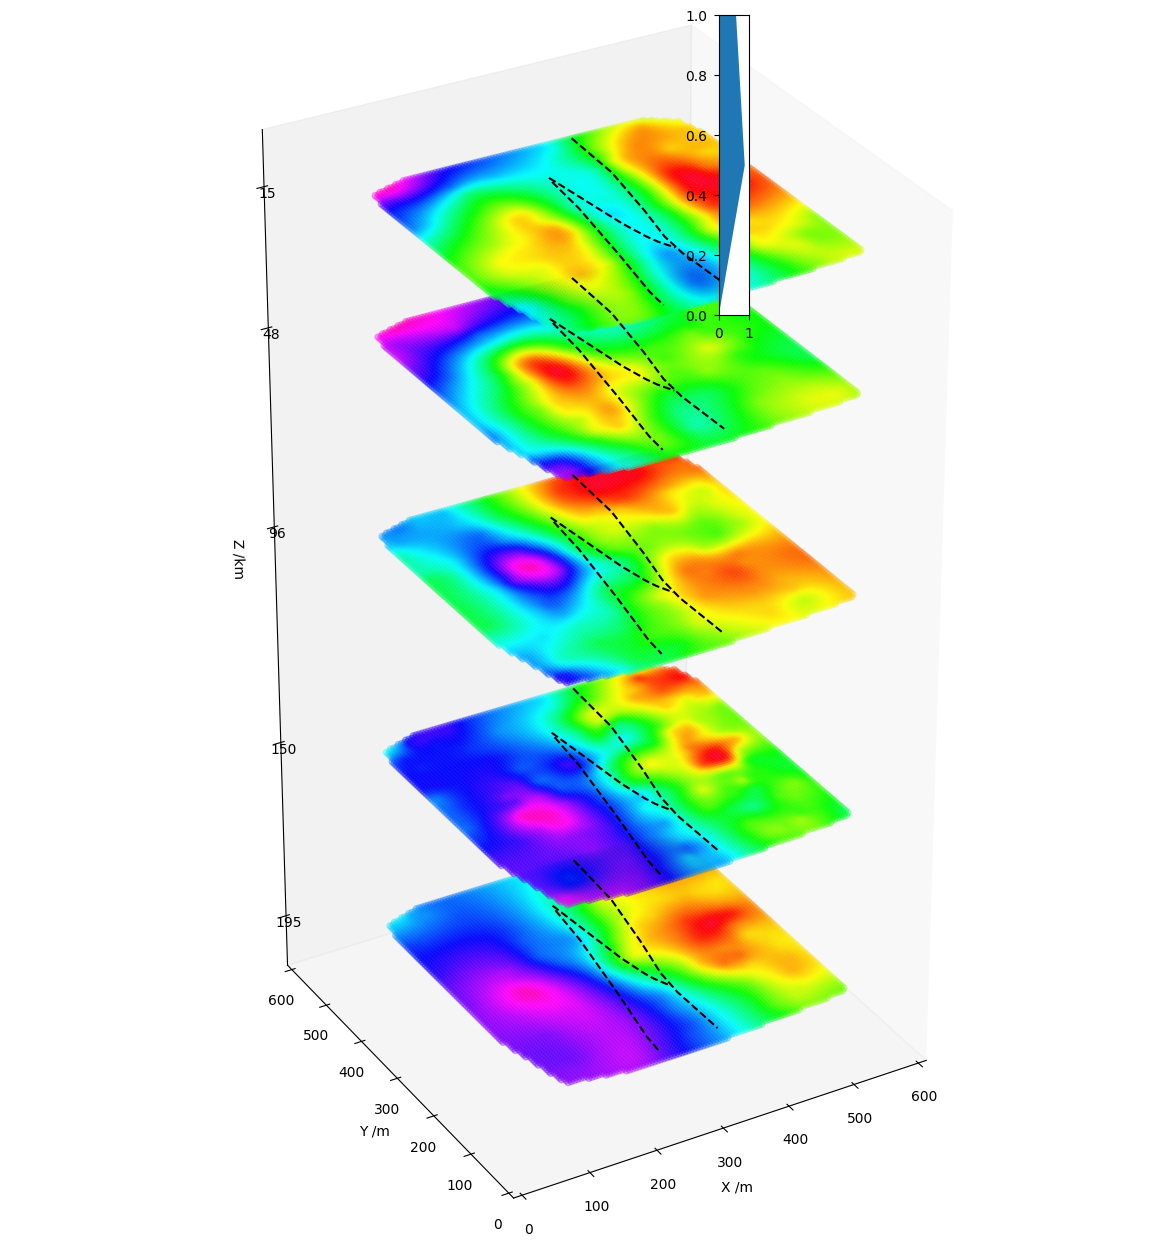

In [29]:
Ns = [5,16,32,50,65]

fig = plt.figure(figsize=(15,15),dpi=100)
ax = fig.add_subplot(1,1,1,projection = '3d')

#ax.view_init(elev=30, azim=-140)
z_sticks = []
for i in Ns:
    z_sticks.append(i*dz)
x = x_inter_in
y = y_inter_in
X,Y = np.meshgrid(x,y)
z = np.ones_like(x)
flag_order = 100
for i in Ns:
    vs_this = vs[i,:]
    z0 = dz*i
    for j in range(len(faults)):
        ax.plot3D(x_faults['clark'+str(j+1)], y_faults['clark'+str(j+1)], z0*np.ones_like(x_faults['clark'+str(j+1)]), 'k--',zorder=flag_order)
    norm = Normalize(vmin=np.min(vs_this), vmax=np.max(vs_this))
    #im = ax.plot_surface(x,y,z,rstride=1, cstride=1, facecolors=plt.cm.gist_rainbow(norm(vs_this)), alpha = 0.7,shade=False,zorder=1)
    
    flag_order -= 1
    im = ax.scatter(x, y, z0, c=vs_this, cmap='gist_rainbow', alpha = 0.3, zorder=flag_order)
    flag_order -= 1
cax = fig.add_axes([0.6, 0.7, 0.02, 0.2])
p = patches.Rectangle((0,0),1,1,angle=30,transform=cax.transData._b)
cax.add_patch(p)
    #cbar = plt.colorbar(im, ax=ax)
#cbar = plt.colorbar(im, ax=ax, shrink=0.5, aspect=10)
ax.tick_params(axis='z', which='major', pad=-10)  # 调整刻度文本与轴的距离
#plt.subplots_adjust(left=0.3, right=0.9, top=0.9, bottom=0.1)
ax.view_init(elev=30, azim=-120)

ax.set_box_aspect([1,1,2])#
#ax.axis('off')
ax.set_xlabel('X /m')
ax.set_ylabel('Y /m')
ax.set_zlabel("Z /km", rotation=-90)
#ax.zaxis.labelpad=-5
#ax.set_xticks(set(x))
ax.set_xlim([0,600])
ax.set_ylim([0,600])
ax.set_zticks(z_sticks)
ax.set_zlim(ax.get_zlim()[::-1])
plt.tick_params(pad=5)
ax.grid(False)

plt.show()
fig.savefig('test.png', bbox_inches='tight')